# Aerial Object Classification & Detection — Bird vs Drone.

## Inspect_dataset

In [9]:
# Cell 1: Imports & config (define TOP_LEVEL here)
import os
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

# Jupyter inline plotting
%matplotlib inline

# reproducible sampling
random.seed(42)

# ------------- EDIT THIS PATH IF NEEDED -------------
# Use raw string r"..." or forward slashes to avoid backslash escape issues.
TOP_LEVEL = Path(r"F:/Data Science/ML Projects/Labmentix/Aerial Object Classification & Detection/Data")
# ----------------------------------------------------

# If you know the precise folder name for classification/detection, set them here; otherwise leave None.
PREFERRED_CLASSIFICATION_FOLDER_NAME = None   # e.g., "classification_dataset"
PREFERRED_DETECTION_FOLDER_NAME = None        # e.g., "object_detection_Dataset"

print("TOP_LEVEL set to:", TOP_LEVEL)


TOP_LEVEL set to: F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data


In [10]:
# Cell 2 (UPDATED): Helper functions + auto-detect classification root

def list_images(folder: Path, exts=(".jpg", ".jpeg", ".png")):
    if not folder.exists():
        return []
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts and p.is_file()]

def safe_open_image(path: Path):
    try:
        with Image.open(path) as im:
            im.load()
            return im.copy()
    except (UnidentifiedImageError, OSError, ValueError):
        return None

def find_classification_root(top_level: Path, preferred_name=None):
    """
    Try to locate the folder that contains train/valid/test (or similar) directories.
    - If preferred_name given, prefer that.
    - Otherwise search subfolders up to depth 3 for folders containing 'train' and/or 'test'.
    """
    if preferred_name:
        candidate = top_level / preferred_name
        if candidate.exists():
            return candidate

    # Check top_level itself
    if any((top_level / s).exists() for s in ["train", "valid", "test"]):
        return top_level

    # Walk subdirs up to depth 3
    for root, dirs, files in os.walk(top_level):
        rel = Path(root)
        if any((rel / s).exists() for s in ["train", "valid", "test"]):
            return rel
        # limit depth
        if len(rel.relative_to(top_level).parts) >= 3:
            # don't descend further
            dirs[:] = []

    return None

# locate classification root
CLASSIFICATION_ROOT = find_classification_root(TOP_LEVEL, PREFERRED_CLASSIFICATION_FOLDER_NAME)
if CLASSIFICATION_ROOT is None:
    raise FileNotFoundError(f"Couldn't find a classification root under {TOP_LEVEL}. "
                            "Make sure train/valid/test exists somewhere inside. "
                            "You can also set PREFERRED_CLASSIFICATION_FOLDER_NAME to the exact folder name.")
print("Using classification root:", CLASSIFICATION_ROOT)

# Try to find detection dataset root (optional)
def find_detection_root(top_level: Path, preferred_name=None):
    if preferred_name:
        candidate = top_level / preferred_name
        if candidate.exists():
            return candidate
    # look for folder that contains 'images' and 'labels'
    for root, dirs, files in os.walk(top_level):
        rel = Path(root)
        if (rel / "images").exists() and (rel / "labels").exists():
            return rel
    return None

DETECTION_ROOT = find_detection_root(TOP_LEVEL, PREFERRED_DETECTION_FOLDER_NAME)
if DETECTION_ROOT:
    print("Found detection root:", DETECTION_ROOT)
else:
    print("No detection root found automatically (that's OK if you don't have detection dataset here).")


Using classification root: F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data
No detection root found automatically (that's OK if you don't have detection dataset here).


In [25]:
# Cell 3 (REPLACEMENT - deeper search for actual class folders)

def find_class_dirs_for_split(root: Path, split_name: str):
   
    split_path = root / split_name
    if not split_path.exists():
        # try to find a folder named split deeper
        candidates = [p for p in root.rglob(split_name) if p.is_dir()]
        split_path = candidates[0] if candidates else None
    if not split_path:
        return {}

    # quick preference: look for bird/drone names anywhere under this split
    preferred = {}
    for candidate in split_path.rglob("*"):
        if not candidate.is_dir():
            continue
        if candidate.name.lower() in ("bird", "birds", "drone", "drones"):
            imgs = list_images(candidate)
            if imgs:
                preferred[candidate.name] = len(imgs)
    if preferred:
        # If we found explicit bird/drone dirs, return those
        return dict(sorted(preferred.items()))

    # otherwise, find any folder under split_path that contains images
    candidate_dirs = []
    for d in split_path.rglob("*"):
        if d.is_dir():
            imgs = list_images(d)
            if imgs:
                candidate_dirs.append((d, len(imgs)))

    # If we found many, prefer leaf-level directories (those that don't have subdirs with images)
    leaf_dirs = []
    candidate_paths = [d for d,_ in candidate_dirs]
    for d, cnt in candidate_dirs:
        # check if any other candidate is a child of d; if so, d is not a leaf
        if not any((other != d and other.is_relative_to(d)) for other in candidate_paths):
            leaf_dirs.append((d, cnt))

    # If leaf_dirs is empty, fall back to candidate_dirs
    chosen = leaf_dirs if leaf_dirs else candidate_dirs

    # Filter out folders named exactly as the split (train/valid/test) unless they are the only ones
    filtered = [(d,c) for d,c in chosen if d.name.lower() != split_name.lower()]
    if not filtered and chosen:
        filtered = chosen

    # Build the result mapping: use directory name as class name
    result = {d.name: c for d,c in sorted(filtered, key=lambda x: x[0].name)}
    return result

def get_classification_structure_deep(root: Path):
    structure = {}
    for split in ["train", "valid", "test"]:
        classes_map = find_class_dirs_for_split(root, split)
        if classes_map:
            structure[split] = classes_map
    return structure

# Run detection and also show some diagnostics
structure = get_classification_structure_deep(CLASSIFICATION_ROOT)
print("Detected structure (split -> {class: count}):")
structure

# Diagnostic: show a few discovered folders (paths) for visibility
print("\nDiagnostic: sample directories under each split that contain images:")
for split in ["train", "valid", "test"]:
    spath = (CLASSIFICATION_ROOT / split)
    if not spath.exists():
        candidates = [p for p in CLASSIFICATION_ROOT.rglob(split) if p.is_dir()]
        spath = candidates[0] if candidates else None
    if spath:
        found = [p for p in spath.rglob("*") if p.is_dir() and list_images(p)]
        print(f"\n{split} -> {len(found)} candidate image-folders (showing up to 8):")
        for p in found[:8]:
            print("  -", p)
    else:
        print(f"\n{split} -> not found")


Detected structure (split -> {class: count}):

Diagnostic: sample directories under each split that contain images:

train -> 3 candidate image-folders (showing up to 8):
  - F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data\train\train
  - F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data\train\train\bird
  - F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data\train\train\drone

valid -> 3 candidate image-folders (showing up to 8):
  - F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data\valid\valid
  - F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data\valid\valid\bird
  - F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data\valid\valid\drone

test -> 3 candidate image-folders (showing up to 8):
  - F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data\test\test


In [26]:
# Cell 4 (REPLACEMENT): Totals and balance check using the deep-discovered structure
from collections import defaultdict

def totals_and_balance(structure):
    totals = defaultdict(int)
    for split, classes in structure.items():
        for cls, cnt in classes.items():
            totals[cls] += cnt
    df = pd.DataFrame.from_dict(structure, orient='index').fillna(0).astype(int)
    if df.empty:
        print("No structure detected.")
        return df, {}
    df.loc["total"] = df.sum(axis=0)
    return df, dict(totals)

df_counts, totals = totals_and_balance(structure)
print("Counts per split and class (corrected if found):")
display(df_counts)
print("Total images per class across splits:", totals)


Counts per split and class (corrected if found):


,bird,drone
train,1414,1248
valid,217,225
test,121,94
total,1752,1567


Total images per class across splits: {'bird': 1752, 'drone': 1567}


In [13]:
# Cell 5: Scan for corrupted images and collect image sizes/aspect ratios

corrupt_images = []
image_sizes = []
aspect_ratios = []

all_images = list_images(CLASSIFICATION_ROOT)
print(f"Found {len(all_images)} images under {CLASSIFICATION_ROOT} (all splits). Scanning...")

for img_path in all_images:
    im = safe_open_image(img_path)
    if im is None:
        corrupt_images.append(img_path)
    else:
        w, h = im.size
        image_sizes.append((w, h))
        if h != 0:
            aspect_ratios.append(round(w / h, 3))

print("Corrupted images found:", len(corrupt_images))
if corrupt_images:
    print("Sample corrupted files (up to 10):")
    for p in corrupt_images[:10]:
        print(" -", p)
else:
    print("No corrupt images detected.")
    
if image_sizes:
    widths = [w for w,h in image_sizes]
    heights = [h for w,h in image_sizes]
    print("Image sizes - width: min/max:", min(widths), "/", max(widths),
          " | height: min/max:", min(heights), "/", max(heights))
else:
    print("No valid images found to report sizes.")


Found 3319 images under F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data (all splits). Scanning...
Corrupted images found: 0
No corrupt images detected.
Image sizes - width: min/max: 416 / 416  | height: min/max: 416 / 416


In [14]:
# Cell 6: Move corrupted images to a 'bad_images' folder for manual review (only if any found)

if corrupt_images:
    BAD_DIR = CLASSIFICATION_ROOT / "bad_images"
    BAD_DIR.mkdir(exist_ok=True)
    moved = 0
    for p in corrupt_images:
        try:
            dst = BAD_DIR / p.name
            p.rename(dst)
            moved += 1
        except Exception as e:
            print("Couldn't move:", p, e)
    print(f"Moved {moved} corrupted images to {BAD_DIR}")
else:
    print("No corrupt images to move.")


No corrupt images to move.


Showing samples for: train


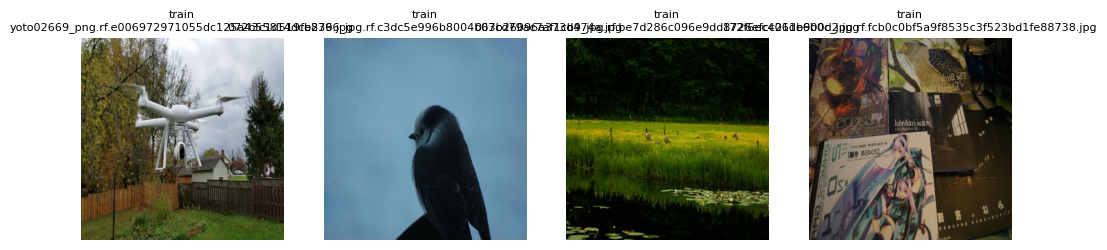

In [15]:
# Cell 7: Visualize sample images per class (train split)

def sample_images_from_folder(folder: Path, n=4):
    images = list_images(folder)
    if not images:
        return []
    return random.sample(images, min(len(images), n))

def plot_samples_for_class(root, split, classname, n=4):
    folder = root / split / classname
    if not folder.exists():
        # attempt nested find
        candidates = [p for p in root.rglob(split) if p.is_dir()]
        if candidates:
            folder = candidates[0] / classname
    if not folder.exists():
        print(f"Folder not found for {split}/{classname} -> {folder}")
        return
    samples = sample_images_from_folder(folder, n=n)
    if not samples:
        print(f"No images in {folder}")
        return
    plt.figure(figsize=(n*3, 3))
    for i, p in enumerate(samples):
        im = Image.open(p)
        plt.subplot(1, n, i+1)
        plt.imshow(im)
        plt.title(f"{classname}\n{p.name}", fontsize=8)
        plt.axis("off")
    plt.show()

# Plot for each class in train (if exists)
train_path = None
if "train" in structure:
    train_path = CLASSIFICATION_ROOT / "train"
    # handle nested train/train case
    if not train_path.exists():
        candidates = [p for p in CLASSIFICATION_ROOT.rglob("train") if p.is_dir()]
        train_path = candidates[0] if candidates else None

if train_path and train_path.exists():
    classes = sorted([d.name for d in train_path.iterdir() if d.is_dir()])
    for cls in classes:
        print(f"Showing samples for: {cls}")
        plot_samples_for_class(CLASSIFICATION_ROOT, "train", cls, n=4)
else:
    print("No train split found to sample from.")


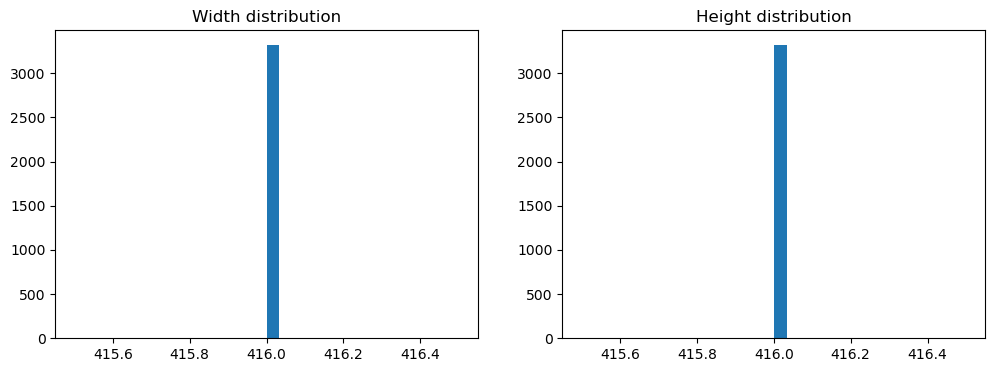

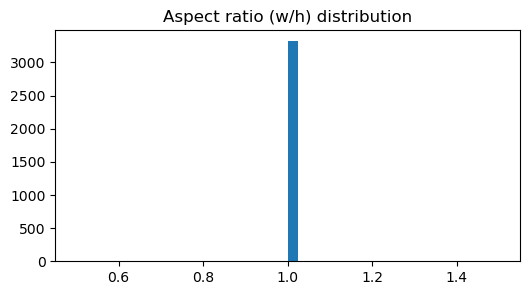

In [16]:
# Cell 8: Plot width/height/aspect-ratio distributions (if we collected sizes)

if image_sizes:
    widths = [w for w,h in image_sizes]
    heights = [h for w,h in image_sizes]
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(widths, bins=30)
    plt.title("Width distribution")
    plt.subplot(1,2,2)
    plt.hist(heights, bins=30)
    plt.title("Height distribution")
    plt.show()

    plt.figure(figsize=(6,3))
    plt.hist(aspect_ratios, bins=40)
    plt.title("Aspect ratio (w/h) distribution")
    plt.show()
else:
    print("No image sizes collected to plot.")


In [17]:
# Cell 9: Create CSV summary with one example image path per split/class + counts

summary = []
for split, classes in structure.items():
    for cls, cnt in classes.items():
        # try to fetch one example image
        example_path = None
        try:
            folder = CLASSIFICATION_ROOT / split / cls
            if not folder.exists():
                candidates = [p for p in CLASSIFICATION_ROOT.rglob(split) if p.is_dir()]
                folder = candidates[0] / cls if candidates else folder
            examples = list_images(folder)
            example_path = str(examples[0]) if examples else None
        except Exception:
            example_path = None

        summary.append({
            "split": split,
            "class": cls,
            "count": cnt,
            "example_path": example_path
        })

summary_df = pd.DataFrame(summary)
summary_csv = Path("dataset_summary.csv")
summary_df.to_csv(summary_csv, index=False)
print("Saved dataset summary to", summary_csv)
display(summary_df)


Saved dataset summary to dataset_summary.csv


,split,class,count,example_path
0,train,train,2662,F:\Data Science\ML Projects\Labmentix\Aerial O...
1,valid,valid,442,F:\Data Science\ML Projects\Labmentix\Aerial O...
2,test,test,215,F:\Data Science\ML Projects\Labmentix\Aerial O...


In [18]:
# Cell 10: Quick check for object detection dataset (YOLO format)

if DETECTION_ROOT:
    img_dir = DETECTION_ROOT / "images"
    lbl_dir = DETECTION_ROOT / "labels"
    img_count = len(list_images(img_dir)) if img_dir.exists() else 0
    label_count = len(list(lbl_dir.rglob("*.txt"))) if lbl_dir.exists() else 0
    print("Detection dataset counts - images:", img_count, "labels (.txt):", label_count)
    sample_text = []
    if lbl_dir.exists() and label_count > 0:
        sample_label = next(lbl_dir.rglob("*.txt"))
        sample_text = sample_label.read_text().strip().splitlines()[:5]
        print("Sample label lines (up to 5):")
        for line in sample_text:
            print("  ", line)
else:
    print("No detection root available; skipped YOLO check.")


No detection root available; skipped YOLO check.


In [19]:
# Cell 11: Optional - check for duplicate filenames across splits (can cause issues)

all_paths = list_images(CLASSIFICATION_ROOT)
names = [p.name for p in all_paths]
dupes = [name for name, ct in Counter(names).items() if ct > 1]
print("Total images scanned:", len(all_paths))
print("Duplicate filenames found (count):", len(dupes))
if dupes:
    print("Sample duplicate filenames (up to 10):", dupes[:10])
else:
    print("No duplicate filenames detected across dataset.")


Total images scanned: 3319
Duplicate filenames found (count): 0
No duplicate filenames detected across dataset.


In [21]:
# Cell 12: conclusion - print short recommendations based on the scan

print("=== INSPECTION SUMMARY ===")
print("Classification root:", CLASSIFICATION_ROOT)
print("Splits found:", list(structure.keys()))
print("Counts table saved to dataset_summary.csv")
if corrupt_images:
    print(f"WARNING: {len(corrupt_images)} corrupted images were found and (if moved) placed in bad_images folder under {CLASSIFICATION_ROOT}")
else:
    print("No corrupted images detected.")
if DETECTION_ROOT:
    print("Detection dataset exists at:", DETECTION_ROOT)
print("\nRecommended next steps:")
print("1) If corrupt images were found, inspect and remove or replace them.")
print("2) Decide on resize target (224x224 recommended).")
print("3) Prepare augmentation pipeline (rotation/flip/brightness/zoom).")
print("4) Create training notebook for Transfer Learning (EfficientNetB0 / ResNet50) or custom CNN.")


=== INSPECTION SUMMARY ===
Classification root: F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data
Splits found: ['train', 'valid', 'test']
Counts table saved to dataset_summary.csv
No corrupted images detected.

Recommended next steps:
1) If corrupt images were found, inspect and remove or replace them.
2) Decide on resize target (224x224 recommended).
3) Prepare augmentation pipeline (rotation/flip/brightness/zoom).
4) Create training notebook for Transfer Learning (EfficientNetB0 / ResNet50) or custom CNN.


## Preprocessing & augmentation

In [27]:
# Cell A: Imports & config
import tensorflow as tf
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

# reuse existing CLASSIFICATION_ROOT from previous cells
print("Using CLASSIFICATION_ROOT =", CLASSIFICATION_ROOT)

# config
IMG_SIZE = (224, 224)      # target size for classification models (EfficientNet, ResNet, etc.)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


Using CLASSIFICATION_ROOT = F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data


In [28]:
# Cell B: Resolve split root that directly contains class subfolders (handles nested train/train case)

def get_split_root(root: Path, split: str) -> Path:
    
    split_path = root / split
    if not split_path.exists():
        # try to find nested
        candidates = [p for p in root.rglob(split) if p.is_dir()]
        split_path = candidates[0] if candidates else None

    if not split_path:
        raise FileNotFoundError(f"Split folder '{split}' not found under {root}")

    # list immediate subdirectories of split_path
    subdirs = [d for d in split_path.iterdir() if d.is_dir()]
    # if immediate subdirs are classes (contain images), return split_path
    if any(len(list(d.glob("*" + ext))) > 0 for d in subdirs for ext in [".jpg", ".jpeg", ".png"]):
        # But verify that those subdirs actually contain image files (leaf level)
        # If subdirs include another folder named exactly split (train/train), skip it
        # We still return split_path if any of its immediate children contain images
        return split_path

    # Otherwise, look one level deeper: find a child that itself has image-containing subdirs
    for child in subdirs:
        grand_children = [g for g in child.iterdir() if g.is_dir()]
        if any(len(list(g.glob("*" + ext))) > 0 for g in grand_children for ext in [".jpg", ".jpeg", ".png"]):
            return child

    # fallback
    return split_path

train_root = get_split_root(CLASSIFICATION_ROOT, "train")
valid_root = get_split_root(CLASSIFICATION_ROOT, "valid")
test_root  = get_split_root(CLASSIFICATION_ROOT, "test")

print("Resolved train root:", train_root)
print("Resolved valid root:", valid_root)
print("Resolved test  root:", test_root)


Resolved train root: F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data\train\train
Resolved valid root: F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data\valid\valid
Resolved test  root: F:\Data Science\ML Projects\Labmentix\Aerial Object Classification & Detection\Data\test\test


In [29]:
# Cell C: Build datasets using image_dataset_from_directory

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="categorical",   # categorical for multi-class (2 classes here)
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_root,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=42,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_root,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=42,
)

class_names = train_ds.class_names
print("Detected classes:", class_names)


Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.
Detected classes: ['bird', 'drone']


In [30]:
# Cell D: Normalize and prepare datasets (cache + prefetch)
# Use a rescaling layer (0-1) inside the pipeline

rescale_layer = tf.keras.layers.Rescaling(1./255)

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x,y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1024)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_prepared = prepare(train_ds, shuffle=True, augment=False)
val_ds_prepared   = prepare(val_ds, shuffle=False, augment=False)
test_ds_prepared  = prepare(test_ds, shuffle=False, augment=False)


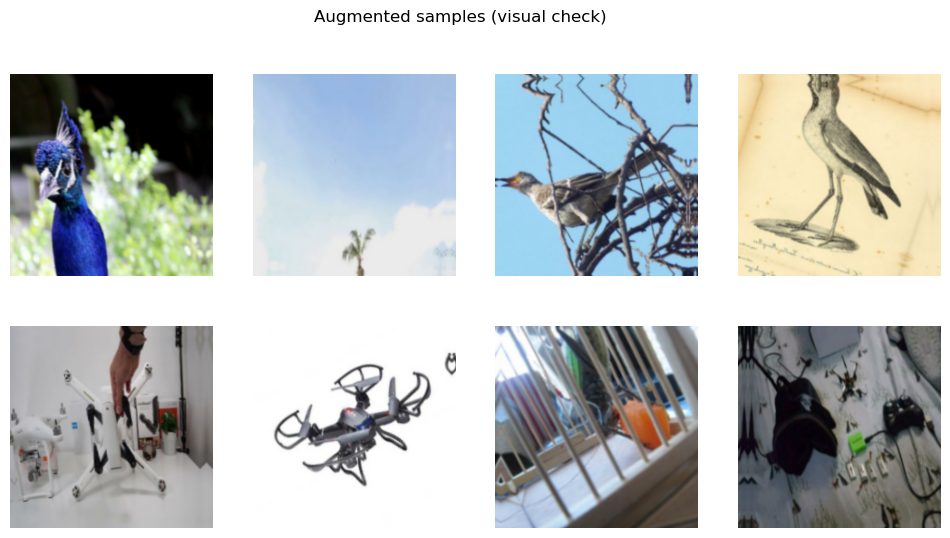

In [31]:
# Cell E: Lightweight augmentation pipeline using tf.keras.layers
# This is fast and runs on GPU when included as part of the model.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),   # ~ +/- 8%
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    # tf.keras.layers.RandomContrast(0.08) # optional
], name="data_augmentation")

# Example: visualize augmented images from a batch
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images, training=True)
    plt.figure(figsize=(12,6))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.suptitle("Augmented samples (visual check)")
    plt.show()
    break


In [32]:
# Cell F: Example model skeleton showing where augmentation fits (we'll replace backbone later)
from tensorflow.keras import layers, models, optimizers, metrics

# simple example model skeleton
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)           # augmentation applied only in training
x = tf.keras.layers.Rescaling(1./255)(x)
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model_example = tf.keras.Model(inputs, outputs)
model_example.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
)
model_example.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,378 (21.01 KB)

 Trainable params: 5,378 (21.01 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Optional: install albumentations if not present
# !pip install albumentations imgaug

import albumentations as A
import cv2

alb_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.Blur(p=0.2),
])

def alb_augment(image):
    # image: uint8 numpy array HWC
    augmented = alb_transform(image=image)
    return augmented["image"]

# To integrate: map a tf.py_function that converts tensors -> numpy -> alb_augment -> tensor
def tf_alb_augment(image, label):
    def f(img):
        img = img.numpy().astype("uint8")
        img = alb_augment(img)
        return img
    aug = tf.py_function(func=f, inp=[image], Tout=tf.uint8)
    aug.set_shape(image.shape)
    aug = tf.cast(aug, tf.float32) / 255.0
    return aug, label

# Example usage (note: slower because of python function)
# train_ds_alb = train_ds.map(tf_alb_augment, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



## Train a Transfer Learning model using EfficientNetB0

In [38]:
# Cell 1: imports & hyperparams
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import json

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 8        # initial head training
EPOCHS_FINE = 15       # fine-tuning
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE = 1e-5
MODEL_DIR = Path("saved_models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)


In [39]:
# Cell 2: compute class weights from training directory counts
# We will compute weights from the dataset_summary or from the directory counts directly.

# Extract labels array from train_ds (it's batched)
labels_list = []
for _, y in train_ds.unbatch().map(lambda x,y: (x,y)).take(1000000):  # take all
    labels_list.append(y.numpy())

# labels_list are one-hot vectors; convert to class indices
labels_idx = np.argmax(np.vstack(labels_list), axis=1)
classes = np.unique(labels_idx)
cw = class_weight.compute_class_weight(class_weight="balanced", classes=classes, y=labels_idx)
class_weights = {int(cls): float(w) for cls, w in zip(classes, cw)}
print("Class weights:", class_weights)


Class weights: {0: 0.9413012729844413, 1: 1.0665064102564104}


In [41]:
# Diagnostic: check TF/Keras versions, image data format, and a sample batch shape
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K

print("tf version:", tf.__version__)
try:
    import keras
    print("keras version:", keras.__version__)
except Exception:
    pass

print("image_data_format:", K.image_data_format())   # should usually be 'channels_last'
print("IMG_SIZE variable:", IMG_SIZE)

# Grab one batch from train_ds (if exists) and show shapes and dtype
for images, labels in train_ds.take(1):
    print("train_ds batch shape:", images.shape, "dtype:", images.dtype)
    # show min/max to confirm normalization state
    print("min, max pixel values in batch:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())
    break
else:
    print("train_ds not found in current scope.")


tf version: 2.20.0
keras version: 3.11.3
image_data_format: channels_last
IMG_SIZE variable: (224, 224)
train_ds batch shape: (32, 224, 224, 3) dtype: <dtype: 'float32'>
min, max pixel values in batch: 0.0 255.0


In [42]:
# Fix: recreate datasets with explicit color_mode='rgb', clear session, then rebuild EfficientNetB0

import tensorflow as tf
from pathlib import Path
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K

# 1) Clear any previous session / graphs
tf.keras.backend.clear_session()
print("Keras session cleared. image_data_format:", K.image_data_format())

# 2) Recreate datasets with explicit color_mode='rgb'
# Use the same train_root/valid_root/test_root resolved earlier. Ensure those variables are present.

print("Recreating datasets with color_mode='rgb' and image_size =", IMG_SIZE)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_root,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    color_mode="rgb"    # force RGB (3 channels)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_root,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=42,
    color_mode="rgb"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_root,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=42,
    color_mode="rgb"
)

for images, labels in train_ds.take(1):
    print("New train_ds batch shape:", images.shape, "dtype:", images.dtype)
    break

# 3) Rebuild EfficientNetB0 with explicit input_shape (3 channels)
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers

num_classes = len(train_ds.class_names)
print("Detected classes:", train_ds.class_names, "| num_classes=", num_classes)

try:
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    print("EfficientNetB0 loaded with imagenet weights successfully.")
except Exception as e:
    print("Error while loading EfficientNetB0 with imagenet weights:", e)
    print("Attempting to load without pretrained weights (weights=None).")
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights=None,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    print("EfficientNetB0 loaded with random weights.")

base_model.trainable = False

# Recreate the full model (same head as before)
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)           # reuse augmentation layer
x = layers.Rescaling(1./255)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE_HEAD),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
)
print("Model built. Summary:")
model.summary()



Keras session cleared. image_data_format: channels_last
Recreating datasets with color_mode='rgb' and image_size = (224, 224)
Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.
New train_ds batch shape: (32, 224, 224, 3) dtype: <dtype: 'float32'>
Detected classes: ['bird', 'drone'] | num_classes= 2
Error while loading EfficientNetB0 with imagenet weights: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)
Attempting to load without pretrained weights (weights=None).
EfficientNetB0 loaded with random weights.
Model built. Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,045 (16.70 MB)

 Trainable params: 328,962 (1.25 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [44]:
# B: Train the head (from current 'model'), but with slightly longer schedule for random init
from tensorflow.keras import callbacks
from sklearn.utils import class_weight
import numpy as np
from pathlib import Path

MODEL_DIR = Path("saved_models"); MODEL_DIR.mkdir(exist_ok=True, parents=True)
CHECKPOINT = MODEL_DIR / "best_head_from_scratch.h5"

# Compute class weights robustly
y = []
for _, labels in train_ds_prepared.unbatch().map(lambda x,y: (x,y)):
    y.append(int(np.argmax(labels.numpy())))
y = np.array(y)
classes = np.unique(y)
cw_vals = class_weight.compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weights = {int(c): float(w) for c, w in zip(classes, cw_vals)}
print("Class weights:", class_weights)

cb_list = [
    callbacks.ModelCheckpoint(str(CHECKPOINT), monitor="val_accuracy", save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

# Longer head training because weights=None
history = model.fit(
    train_ds_prepared,
    validation_data=val_ds_prepared,
    epochs=25,               # longer than before because random init
    class_weight=class_weights,
    callbacks=cb_list
)

# save final
model.save(MODEL_DIR / "final_head_from_scratch.h5")
print("Training complete. Best checkpoint:", CHECKPOINT)


Class weights: {0: 0.9413012729844413, 1: 1.0665064102564104}
Epoch 1/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.5066 - loss: 0.6930 - precision: 0.4904 - recall: 0.4669
Epoch 1: val_accuracy improved from None to 0.50905, saving model to saved_models\best_head_from_scratch.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 698ms/step - accuracy: 0.4902 - loss: 0.6936 - precision: 0.4882 - recall: 0.4823 - val_accuracy: 0.5090 - val_loss: 0.6930 - val_precision: 0.5090 - val_recall: 0.5090 - learning_rate: 0.0010
Epoch 2/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.5021 - loss: 0.6928 - precision: 0.5021 - recall: 0.5021
Epoch 2: val_accuracy did not improve from 0.50905
84/84 ━━━━━━━━━━━━━━━━━━━━ 56s 665ms/step - accuracy: 0.4914 - loss: 0.6935 - precision: 0.4914 - recall: 0.4914 - val_accuracy: 0.5090 - val_loss: 0.6930 - val_precision: 0.5090 - val_recall: 0.5090 - learning_rate: 0.0010
Epoch 3/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.5090 - loss: 0.6928 - precision: 0.5090 - recall: 0.5090
Epoch 3: val_accuracy did not improve from 0.50905
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 661ms/step - accuracy: 0.4921 - loss: 0.6935 - precision: 0.4921 - recall: 0.4921 - val_accuracy: 0.5090 - val_loss: 0.6930 - val_precision: 0.5090 - val_recall: 0.5090 - le

Training complete. Best checkpoint: saved_models\best_head_from_scratch.h5


## Re-download pretrained EfficientNet weights

In [45]:
# REMOVE cached EfficientNet weights & retry loading pretrained EfficientNetB0
import shutil, os
from pathlib import Path
import tensorflow as tf

home = Path.home()
cand_dirs = [
    home / ".keras" / "models",
    home / ".cache" / "keras" / "models",
    Path(os.getenv('KERAS_HOME', '')) / "models" if os.getenv('KERAS_HOME') else None
]
cand_dirs = [p for p in cand_dirs if p]

removed = []
for d in cand_dirs:
    if not d.exists(): 
        continue
    for p in d.glob("*efficientnet*"):
        try:
            p.unlink()
            removed.append(str(p))
        except Exception:
            try:
                shutil.rmtree(p)
                removed.append(str(p))
            except Exception as e:
                print("Couldn't remove", p, e)

print("Removed files:", removed)

# Try loading EfficientNetB0 now
try:
    base = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3))
    print("✅ EfficientNetB0 loaded with imagenet weights.")
except Exception as e:
    print("⚠️ Still failed to download/load imagenet weights. Error:\n", e)
    print("You can either investigate your Keras cache directory manually or proceed with weights=None.")


Removed files: ['C:\\Users\\HP\\.keras\\models\\efficientnetb0_notop.h5']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 16s 1us/step
⚠️ Still failed to download/load imagenet weights. Error:
 Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)
You can either investigate your Keras cache directory manually or proceed with weights=None.


In [46]:
# CELL 2: Build model with MobileNetV2 backbone (PRETRAINED)

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

tf.keras.backend.clear_session()

num_classes = len(train_ds.class_names)
IMG_SIZE = (224,224)

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False   # freeze backbone initially

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)         # your augmentation layer
x = layers.Rescaling(1./255)(x)       # normalize
x = base_model(x, training=False)     
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,458 (9.87 MB)

 Trainable params: 328,962 (1.25 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [47]:
from tensorflow.keras import callbacks
from pathlib import Path
import numpy as np

MODEL_DIR = Path("saved_models_mobilenet")
MODEL_DIR.mkdir(exist_ok=True, parents=True)
CHECKPOINT = MODEL_DIR / "best_head.h5"

cb = [
    callbacks.ModelCheckpoint(str(CHECKPOINT), monitor="val_accuracy", save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

history = model.fit(
    train_ds_prepared,
    validation_data=val_ds_prepared,
    epochs=10,
    class_weight=class_weights,
    callbacks=cb
)

print("Best checkpoint saved to:", CHECKPOINT)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4863 - loss: 1.0242
Epoch 1: val_accuracy improved from None to 0.62670, saving model to saved_models_mobilenet\best_head.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 51s 551ms/step - accuracy: 0.4940 - loss: 0.9485 - val_accuracy: 0.6267 - val_loss: 0.6704 - learning_rate: 0.0010
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5250 - loss: 0.8044
Epoch 2: val_accuracy did not improve from 0.62670
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 494ms/step - accuracy: 0.5263 - loss: 0.7908 - val_accuracy: 0.5068 - val_loss: 0.6643 - learning_rate: 0.0010
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5290 - loss: 0.7541
Epoch 3: val_accuracy did not improve from 0.62670
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 487ms/step - accuracy: 0.5222 - loss: 0.7554 - val_accuracy: 0.4910 - val_loss: 0.8735 - learning_rate: 0.0010
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5204 - loss: 0.7381
Epoch 4: val_accuracy did not improve from 0.62670

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 487ms/step - accuracy: 0.5319 - loss: 0.7282 - val_accu

84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 496ms/step - accuracy: 0.5413 - loss: 0.7032 - val_accuracy: 0.6923 - val_loss: 0.6528 - learning_rate: 5.0000e-04
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.5498 - loss: 0.6944
Epoch 7: val_accuracy did not improve from 0.69231
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 506ms/step - accuracy: 0.5500 - loss: 0.6899 - val_accuracy: 0.5520 - val_loss: 0.6558 - learning_rate: 5.0000e-04
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.5436 - loss: 0.6887
Epoch 8: val_accuracy did not improve from 0.69231
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 484ms/step - accuracy: 0.5541 - loss: 0.6876 - val_accuracy: 0.6923 - val_loss: 0.6520 - learning_rate: 5.0000e-04
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.5481 - loss: 0.6940
Epoch 9: val_accuracy did not improve from 0.69231
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 494ms/step - accuracy: 0.5503 - loss: 0.6921 - val_accuracy: 0.5520 - val_loss: 0.6545 - learning_rate: 5.0000e-04
Epoch

In [48]:
# CELL 4: Fine-tune

base_model.trainable = True

# unfreeze last 20% of layers
fine_tune_at = int(len(base_model.layers) * 0.8)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

CHECKPOINT_FT = MODEL_DIR / "best_finetune.h5"

cb_ft = [
    callbacks.ModelCheckpoint(str(CHECKPOINT_FT), monitor="val_accuracy", save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
]

history_fine = model.fit(
    train_ds_prepared,
    validation_data=val_ds_prepared,
    epochs=15,
    class_weight=class_weights,
    callbacks=cb_ft
)

print("Fine-tuned checkpoint saved to:", CHECKPOINT_FT)


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.5736 - loss: 1.0053
Epoch 1: val_accuracy improved from None to 0.50905, saving model to saved_models_mobilenet\best_finetune.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 747ms/step - accuracy: 0.6131 - loss: 0.8701 - val_accuracy: 0.5090 - val_loss: 1.5337
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.6770 - loss: 0.6948
Epoch 2: val_accuracy did not improve from 0.50905
84/84 ━━━━━━━━━━━━━━━━━━━━ 61s 726ms/step - accuracy: 0.6799 - loss: 0.6669 - val_accuracy: 0.5090 - val_loss: 2.9885
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.6992 - loss: 0.6381
Epoch 3: val_accuracy did not improve from 0.50905
84/84 ━━━━━━━━━━━━━━━━━━━━ 62s 733ms/step - accuracy: 0.6946 - loss: 0.6195 - val_accuracy: 0.5090 - val_loss: 5.1783
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.7056 - loss: 0.5967
Epoch 4: val_accuracy did not improve from 0.50905
84/84 ━━━━━━━━━━━━━━━━━━━━ 57s 680ms/step - accuracy: 0.7051 - loss: 0.5918 - val_accuracy: 0.5090 - val_loss: 6.5470
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.7084 - loss: 0.5859
Epoch 5: val_accuracy did not i

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Test Accuracy: 0.4372093023255814

Classification Report:
               precision    recall  f1-score   support

        bird       0.00      0.00      0.00       121
       drone       0.44      1.00      0.61        94

    accuracy                           0.44       215
   macro avg       0.22      0.50      0.30       215
weighted avg       0.19      0.44      0.27       215



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


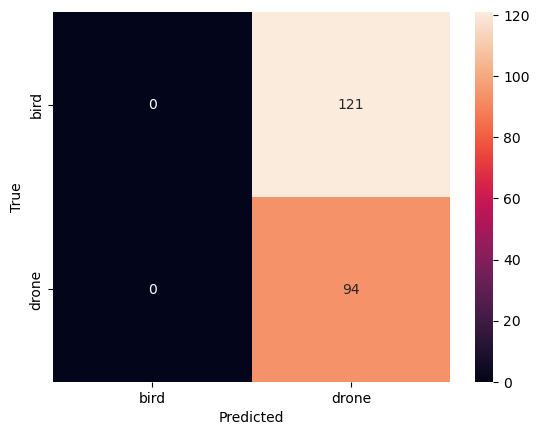

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

best_model = tf.keras.models.load_model(CHECKPOINT_FT)

y_true, y_pred = [], []

for images, labels in test_ds_prepared:
    preds = best_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("Test Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=train_ds.class_names))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


#### Confirm class_names and counts used by train/val/test

In [50]:
# check class names and counts in each split
from collections import Counter
def counts_from_ds(ds):
    labels=[]
    for _, y in ds.unbatch().map(lambda x,y:(x,y)).take(1000000):
        labels.append(int(y.numpy().argmax()))
    return Counter(labels)

print("train class_names:", train_ds.class_names)
print("val class_names:  ", val_ds.class_names)
print("test class_names: ", test_ds.class_names)

print("train counts (indices):", counts_from_ds(train_ds))
print("val counts (indices):", counts_from_ds(val_ds))
print("test counts (indices):", counts_from_ds(test_ds))


train class_names: ['bird', 'drone']
val class_names:   ['bird', 'drone']
test class_names:  ['bird', 'drone']
train counts (indices): Counter({0: 1414, 1: 1248})
val counts (indices): Counter({1: 225, 0: 217})
test counts (indices): Counter({0: 121, 1: 94})


#### Evaluate both checkpoints (head-only vs fine-tuned)

Evaluating HEAD checkpoint


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model: saved_models_mobilenet/best_head.h5
Accuracy: 0.7534883720930232
              precision    recall  f1-score   support

        bird       0.72      0.91      0.81       121
       drone       0.83      0.55      0.66        94

    accuracy                           0.75       215
   macro avg       0.77      0.73      0.73       215
weighted avg       0.77      0.75      0.74       215



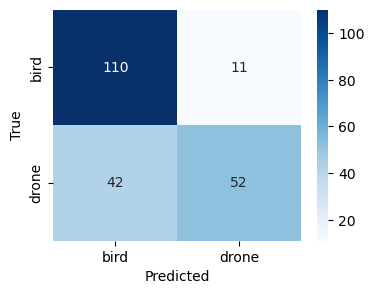

Evaluating FINE-TUNED checkpoint


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model: saved_models_mobilenet/best_finetune.h5
Accuracy: 0.4372093023255814
              precision    recall  f1-score   support

        bird       0.00      0.00      0.00       121
       drone       0.44      1.00      0.61        94

    accuracy                           0.44       215
   macro avg       0.22      0.50      0.30       215
weighted avg       0.19      0.44      0.27       215



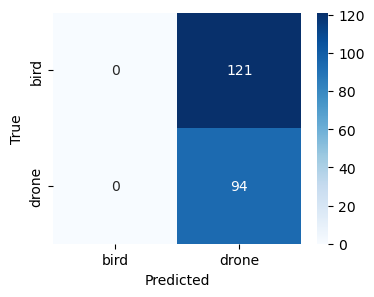

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [51]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

def eval_model(path, ds, class_names):
    m = tf.keras.models.load_model(path)
    y_true=[]; y_pred=[]
    for imgs, labs in ds:
        preds = m.predict(imgs)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labs.numpy(), axis=1))
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    print("Model:", path)
    print("Accuracy:", (y_true==y_pred).mean())
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
    return y_true, y_pred

# Replace paths with your saved model files
head_path = "saved_models_mobilenet/best_head.h5"       # good head checkpoint
ft_path   = "saved_models_mobilenet/best_finetune.h5"  # fine-tuned checkpoint
print("Evaluating HEAD checkpoint")
eval_model(head_path, test_ds_prepared, train_ds.class_names)
print("Evaluating FINE-TUNED checkpoint")
eval_model(ft_path, test_ds_prepared, train_ds.class_names)


#### Inspect predicted probabilities on some samples (see whether model is confident)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


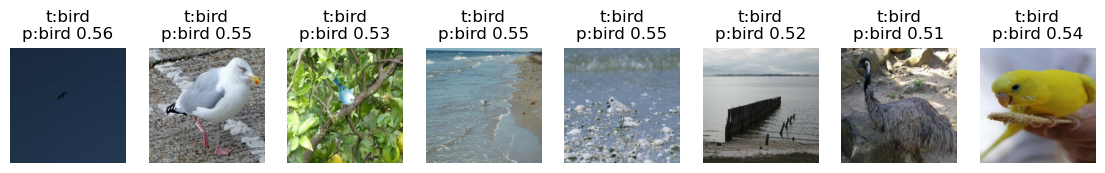

In [52]:
# Show a few test images with predicted probs
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model(head_path)  # or ft_path

def show_preds(ds, model, n=8):
    for imgs, labs in ds.unbatch().batch(n).take(1):
        preds = model.predict(imgs)
        probs = np.max(preds, axis=1)
        pred_idx = np.argmax(preds, axis=1)
        true_idx = np.argmax(labs.numpy(), axis=1)
        plt.figure(figsize=(14,4))
        for i in range(len(imgs)):
            plt.subplot(1,len(imgs),i+1)
            plt.imshow((imgs[i].numpy()*255).astype('uint8'))  # if pre-scaled
            plt.title(f"t:{train_ds.class_names[true_idx[i]]}\np:{train_ds.class_names[pred_idx[i]]} {probs[i]:.2f}")
            plt.axis('off')
        plt.show()
        break

show_preds(test_ds_prepared, model, n=8)


#### Re-evaluate head to confirm

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Head Test Accuracy: 0.7534883720930232
              precision    recall  f1-score   support

        bird       0.72      0.91      0.81       121
       drone       0.83      0.55      0.66        94

    accuracy                           0.75       215
   macro avg       0.77      0.73      0.73       215
weighted avg       0.77      0.75      0.74       215



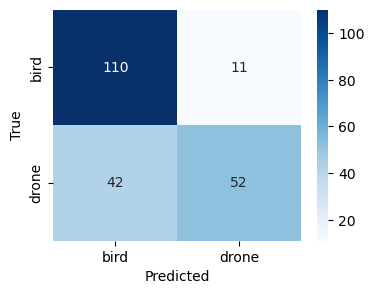

In [53]:
import tensorflow as tf, numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

head_path = "saved_models_mobilenet/best_head.h5"
m_head = tf.keras.models.load_model(head_path)

y_true=[]; y_pred=[]
for imgs, labs in test_ds_prepared:
    preds = m_head.predict(imgs)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labs.numpy(), axis=1))

import numpy as np
y_true = np.array(y_true); y_pred = np.array(y_pred)
print("Head Test Accuracy:", (y_true==y_pred).mean())
print(classification_report(y_true, y_pred, target_names=train_ds.class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_ds.class_names, yticklabels=train_ds.class_names, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()


#### Safe fine-tune

In [54]:
# SAFE FINE-TUNE: unfreeze only last 10% of base_model layers, very low lr
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks
from pathlib import Path
tf.keras.backend.clear_session()

HEAD_PATH = "saved_models_mobilenet/best_head.h5"
FINE_CHECKPOINT = Path("saved_models_mobilenet/best_finetune_safe.h5")
print("Loading head from:", HEAD_PATH)
model = tf.keras.models.load_model(HEAD_PATH)

# find the base backbone layer by name (MobileNetV2 name used when we built earlier)
# adjust the name if different — print(model.summary()) if necessary
base_layer = None
for layer in model.layers:
    if "mobilenet" in layer.name.lower() or "mobilenetv2" in layer.name.lower():
        base_layer = layer
        break
if base_layer is None:
    raise RuntimeError("Couldn't find the backbone layer inside the loaded model. Inspect model.summary() to get the correct base layer name.")

print("Found base model layer:", base_layer.name, "| total base layers:", len(base_layer.layers))

# Unfreeze only last 10% of base layers
n = len(base_layer.layers)
unfreeze_at = int(n * 0.90)    # keep first 90% frozen, unfreeze last 10%
for i, l in enumerate(base_layer.layers):
    l.trainable = (i >= unfreeze_at)

# Verify how many trainable params
trainable_count = sum([tf.size(tf.convert_to_tensor(w)).numpy() for w in model.trainable_weights])
non_trainable_count = sum([tf.size(tf.convert_to_tensor(w)).numpy() for w in model.non_trainable_weights])
print("Trainable params (approx):", trainable_count, "Non-trainable params:", non_trainable_count)

# Compile with very low LR
model.compile(
    optimizer=optimizers.Adam(1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# callbacks
cb = [
    callbacks.ModelCheckpoint(str(FINE_CHECKPOINT), monitor="val_accuracy", save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

# Fine-tune: short run
history_ft = model.fit(
    train_ds_prepared,
    validation_data=val_ds_prepared,
    epochs=8,
    class_weight=class_weights,
    callbacks=cb
)

print("Safe fine-tune done. Best saved to:", FINE_CHECKPOINT)


Loading head from: saved_models_mobilenet/best_head.h5


Found base model layer: mobilenetv2_1.00_224 | total base layers: 154
Trainable params (approx): 1370882 Non-trainable params: 1216576
Epoch 1/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.4935 - loss: 1.1763
Epoch 1: val_accuracy improved from None to 0.50679, saving model to saved_models_mobilenet\best_finetune_safe.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 562ms/step - accuracy: 0.5030 - loss: 1.1450 - val_accuracy: 0.5068 - val_loss: 0.6583 - learning_rate: 1.0000e-06
Epoch 2/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.5321 - loss: 1.0970
Epoch 2: val_accuracy improved from 0.50679 to 0.50905, saving model to saved_models_mobilenet\best_finetune_safe.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 549ms/step - accuracy: 0.5394 - loss: 1.0827 - val_accuracy: 0.5090 - val_loss: 0.8418 - learning_rate: 1.0000e-06
Epoch 3/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5388 - loss: 1.0860
Epoch 3: val_accuracy did not improve from 0.50905

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 541ms/step - accuracy: 0.5424 - loss: 1.0657 - val_accuracy: 0.5090 - val_loss: 1.4646 - learning_rate: 1.0000e-06
Epoch 4/8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5664 - loss: 0.9369
Epoch 4: val_accuracy did not improve from 0.50905
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 544ms/step - accuracy: 0.5665 - loss: 0.9618 - val_accuracy: 0.5090 - val_loss: 2.6356 - learning_rate: 5.0000e-07
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Safe fine-tune done. Best saved to: saved_models_mobilenet\best_finetune_safe.h5


In [55]:
# EXPORT head model to native Keras format and test single inference
import tensorflow as tf, numpy as np
from pathlib import Path
from PIL import Image

head_path = "saved_models_mobilenet/best_head.h5"
model = tf.keras.models.load_model(head_path)
EXPORT = Path("deploy_models")
EXPORT.mkdir(exist_ok=True)
model.save(EXPORT / "bird_vs_drone_model.keras")   # recommended format

print("Saved model to:", EXPORT / "bird_vs_drone_model.keras")

# quick test on one image from test set
sample_img_path = list(test_root.rglob("*.jpg"))[0]  # adjust if different extension
img = Image.open(sample_img_path).resize((224,224))
arr = np.array(img).astype("float32") / 255.0
arr = np.expand_dims(arr, 0)
pred = model.predict(arr)[0]
print("Pred probs:", pred, "pred label:", train_ds.class_names[np.argmax(pred)])


Saved model to: deploy_models\bird_vs_drone_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Pred probs: [0.5558816  0.44411844] pred label: bird
